In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense

model_name = "PE_classification_224_160_48_1_2_g_best2.h5"

# Folder "nr_128_64" consist of CT scans having normal lung tissue or other lung disease

normal_scan_paths2 = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/val/nr", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/val/nr")
]
# Folder "pe_128_64" consist of CT scans having Pulmonary embolism,

abnormal_scan_paths2 = [
    os.path.join(os.getcwd(),"C:/Users/85298/AI/PE0415/val/pe", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/val/pe")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths2)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths2)))


####################################################

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
#   Read and load volume
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


abnormal_scans2 = np.array([read_nifti_file(path) for path in abnormal_scan_paths2])
normal_scans2 = np.array([read_nifti_file(path) for path in normal_scan_paths2])

nr100 = round(len(normal_scan_paths2)  )
pe100 = round(len(abnormal_scan_paths2)   )


#print("nr70%:",nr70,"nr30%",nr30)
#print("pe70%:",pe70,"pe30%:",pe30)

# For the CT scans having Pulmonary embolism
# assign 1, for the normal and other disease ones assign 0.
abnormal_labels2 = np.array([1 for _ in range(len(abnormal_scans2))])
normal_labels2 = np.array([0 for _ in range(len(normal_scans2))])

# Split data in the ratio 70-30 for training and validation.
x_train2 = np.concatenate((abnormal_scans2[:pe100], normal_scans2[:nr100]), axis=0)
y_train2 = np.concatenate((abnormal_labels2[:pe100], normal_labels2[:nr100]), axis=0)
x_val2 = np.concatenate((abnormal_scans2[pe100:], normal_scans2[nr100:]), axis=0)
y_val2 = np.concatenate((abnormal_labels2[pe100:], normal_labels2[nr100:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train2.shape[0], x_val2.shape[0])
)


CT scans with normal lung tissue: 26
CT scans with abnormal lung tissue: 14
Number of samples in train and validation are 40 and 0.


In [2]:
from keras.utils import np_utils
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, SGD
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import time
import os
import numpy as np
import keras
import h5py
import numpy as np
from keras import regularizers
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
import keras
import tensorflow as tf

def get_model():
    
    input_layer = Input((224, 160, 48, 1))
    
    conv_layer1 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)
    pooling_layer1 = BatchNormalization()(pooling_layer1) 
   
    
    conv_layer2 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
    pooling_layer2 = BatchNormalization()(pooling_layer2)  

    
    conv_layer3 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu')(pooling_layer2)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)
    pooling_layer3 = BatchNormalization()(pooling_layer3)

    
    conv_layer4 = Conv3D(filters=1024, kernel_size=(3, 3, 3), activation='relu')(pooling_layer3)
    pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
    pooling_layer4 = BatchNormalization()(pooling_layer4)
    
    flatten_layer = Flatten()(pooling_layer4)
    
    dense_layer4 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer4 = Dropout(0.4)(dense_layer4)
    
    
    dense_layer5 = Dense(units=1024, activation='relu')(dense_layer4)
    dense_layer5 = Dropout(0.4)(dense_layer5)
    
    output_layer = Dense(units=1, activation="sigmoid")(dense_layer5)    

    model = Model(inputs=input_layer, outputs=output_layer, name="3dcnn")
   
    return model

model = None
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 111, 79, 23, 128)  0        
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 79, 23, 128)  512      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 109, 77, 21, 256)  884992

In [3]:
import warnings 
warnings.simplefilter(action='ignore',category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd
import csv
from keras.models import load_model

df_label = pd.read_csv('C:/Users/85298/AI/CT_image/202304/label_cut_d.csv' , sep=',')
y=df_label.set_index("ID3", inplace = True)


df_out = pd.DataFrame(columns = ["ID","Disease","Label","predict", "actual"])
df_out2 = pd.DataFrame(columns = ["predict", "actual"])

len_nr = len(normal_scan_paths2)
len_pe = len(abnormal_scan_paths2)


for patient in range (0,len(y_train2)):

#for patient in range (0,20):
    
    if patient < len_pe:
    
        file_path = abnormal_scan_paths2[patient]
    
    else :
        
        file_path = normal_scan_paths2 [patient-len_pe]
        
    ID = file_path.split("_") [2]


    
    Disease = df_label.loc[int(ID)]["Disease"]    

    Label = df_label.loc[int(ID)]["Label"] 
    

    

# Load best weights.


    model.load_weights(model_name)
    prediction = model.predict(np.expand_dims(x_train2[patient], axis=0))[0]
    label_1 = y_train2[patient]
    
    scores = [1 - prediction[0], prediction[0]]
 #   print(label_1)
     
    prediction_score = round(prediction[0] *100,2)
    prediction_score2 = prediction[0] *100
        
    df_out = df_out.append({"ID": ID,"Disease":Disease,"Label":Label ,'predict' : prediction_score , 'actual' : label_1 },
        ignore_index = True)

    df_out2 = df_out2.append({'predict' : prediction_score2 , 'actual' : label_1 },
        ignore_index = True)
    
    
print(df_out)    


    
    

                
    
        




1/1 [==============================] - 0s 15ms/step
      ID                                Disease  Label  predict actual
0   1018                             Chronic PE     PE    20.10      1
1   2001                                     PE     PE    19.66      1
2   4038             Chronic pulmonary embolism     PE    25.56      1
3   4053             Pulmonary embolism present     PE    14.90      1
4   5004             Pulmonary embolism present     PE    78.87      1
5   5012             Pulmonary embolism present     PE    43.55      1
6   5015  Non diagnostic for pulmonary embolism     PE    27.88      1
7   5024  Non diagnostic for pulmonary embolism     PE    83.49      1
8   5026             Pulmonary embolism present     PE    28.91      1
9   6001                                Present     PE     7.84      1
10  6009                                Present     PE    54.95      1
11  6016                                Present     PE    30.22      1
12  6033                 

In [5]:
import numpy as np
import pandas as pd
import csv
from keras.models import load_model

for i in np.arange (1,99,1):
    
    i = round(i,2)

    TP = 0
    FP = 0
    TN = 0
    FN = 0


    for patient in range (0,len(df_out)):
    

        if (df_out["predict"].iloc[patient] > i) & (df_out["actual"].iloc[patient] == 1) :
            TP = TP + 1
        if (df_out["predict"].iloc[patient] > i) & (df_out["actual"].iloc[patient] == 0) :
            FP = FP + 1
        if (df_out["predict"].iloc[patient] < i) & (df_out["actual"].iloc[patient] == 0) :
            TN = TN + 1
        if (df_out["predict"].iloc[patient] < i) & (df_out["actual"].iloc[patient] == 1) :
            FN = FN + 1        
        

    Precision = TP/(TP+FP)

    Recall = TP/(TP+FN)

    F1_score = ((Precision*Recall)/(Precision+Recall))*2

    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    print(str(i))
    print ("Precision",Precision,"Recall",Recall,"F1_score",F1_score,"Accuracy",Accuracy)
    print (TP,FP,TN,FN)           



1
Precision 0.358974358974359 Recall 1.0 F1_score 0.5283018867924528 Accuracy 0.375
14 25 1 0
2
Precision 0.3684210526315789 Recall 1.0 F1_score 0.5384615384615384 Accuracy 0.4
14 24 2 0
3
Precision 0.3783783783783784 Recall 1.0 F1_score 0.5490196078431372 Accuracy 0.425
14 23 3 0
4
Precision 0.3783783783783784 Recall 1.0 F1_score 0.5490196078431372 Accuracy 0.425
14 23 3 0
5
Precision 0.3888888888888889 Recall 1.0 F1_score 0.56 Accuracy 0.45
14 22 4 0
6
Precision 0.3888888888888889 Recall 1.0 F1_score 0.56 Accuracy 0.45
14 22 4 0
7
Precision 0.3888888888888889 Recall 1.0 F1_score 0.56 Accuracy 0.45
14 22 4 0
8
Precision 0.37142857142857144 Recall 0.9285714285714286 F1_score 0.5306122448979592 Accuracy 0.425
13 22 4 1
9
Precision 0.38235294117647056 Recall 0.9285714285714286 F1_score 0.5416666666666667 Accuracy 0.45
13 21 5 1
10
Precision 0.38235294117647056 Recall 0.9285714285714286 F1_score 0.5416666666666667 Accuracy 0.45
13 21 5 1
11
Precision 0.3939393939393939 Recall 0.9285714285

ZeroDivisionError: division by zero

In [6]:
import numpy as np
import pandas as pd
import csv
from keras.models import load_model

for i in np.arange (20,21,1):
    
    i = round(i,2)

    TP = 0
    FP = 0
    TN = 0
    FN = 0


    for patient in range (0,len(df_out)):
    

        if (df_out["predict"].iloc[patient] > i) & (df_out["actual"].iloc[patient] == 1) :
            TP = TP + 1
        if (df_out["predict"].iloc[patient] > i) & (df_out["actual"].iloc[patient] == 0) :
            FP = FP + 1
        if (df_out["predict"].iloc[patient] < i) & (df_out["actual"].iloc[patient] == 0) :
            TN = TN + 1
        if (df_out["predict"].iloc[patient] < i) & (df_out["actual"].iloc[patient] == 1) :
            FN = FN + 1        
        

    Precision = TP/(TP+FP)

    Recall = TP/(TP+FN)

    F1_score = ((Precision*Recall)/(Precision+Recall))*2

    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    print(str(i))
    print ("Precision",Precision,"Recall",Recall,"F1_score",F1_score,"Accuracy",Accuracy)
    print (TP,FP,TN,FN)           

20
Precision 0.5789473684210527 Recall 0.7857142857142857 F1_score 0.6666666666666667 Accuracy 0.725
11 8 18 3


Text(0.5, 192.72222222222217, 'Predicted')

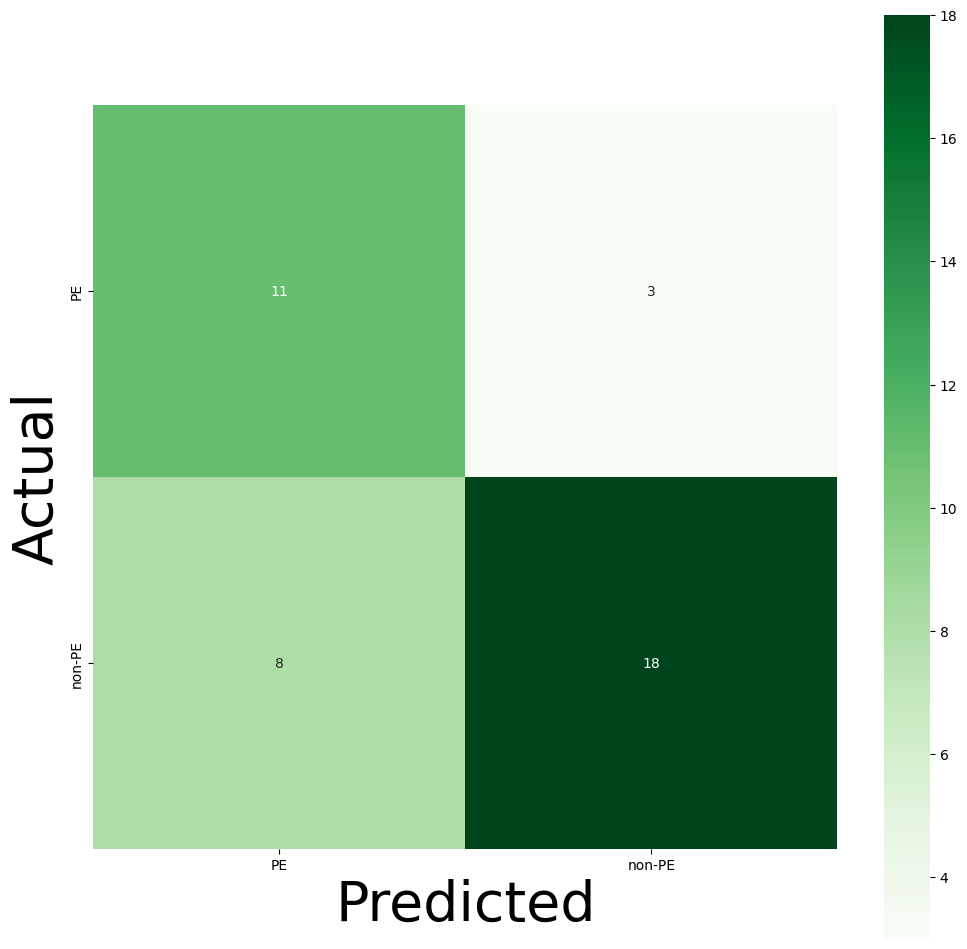

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Y_pred = model.predict(x_val)
disease_types=['PE', 'non-PE']



#Y_pred = np.argmax(Y_pred, axis=1)
#Y_true = y_val
#Y_true = np.argmax(y_val,axis=1)
#print (Y_pred)
#print (Y_true)
#cm = confusion_matrix(Y_true, Y_pred)

cm = [[TP,FN],[FP,TN]]

plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

[0.         0.         0.         0.03846154 0.03846154 0.26923077
 0.26923077 0.30769231 0.30769231 0.34615385 0.34615385 0.57692308
 0.57692308 0.84615385 0.84615385 1.        ] [0.         0.07142857 0.14285714 0.14285714 0.35714286 0.35714286
 0.64285714 0.64285714 0.78571429 0.78571429 0.85714286 0.85714286
 0.92857143 0.92857143 1.         1.        ] [84.49213004 83.49213004 78.86624336 73.14296961 43.55053902 30.88115752
 27.8809607  25.88546574 20.10094374 19.96827275 19.66100931 15.42372108
 14.90159035  8.11952204  7.83622116  0.98222243]


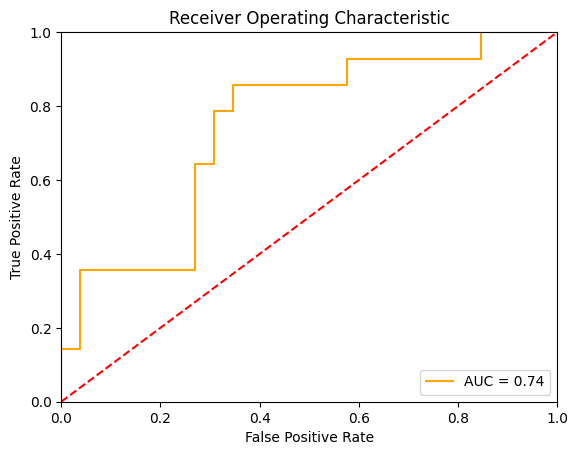

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 讀取資料
import pandas as pd
#df=pd.read_csv('./AUC.csv')

# 在各種『決策門檻』（decision threshold）下，計算 『真陽率』（True Positive Rate；TPR）與『假陽率』（False Positive Rate；FPR）
fpr, tpr, threshold = roc_curve(df_out2['actual'], df_out2['predict'])
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()  

#### 

In [9]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense


# Folder "nr_128_64" consist of CT scans having normal lung tissue or other lung disease

normal_scan_paths2 = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/test/nr", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/test/nr")
]
# Folder "pe_128_64" consist of CT scans having Pulmonary embolism,

abnormal_scan_paths2 = [
    os.path.join(os.getcwd(),"C:/Users/85298/AI/PE0415/test/pe", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/test/pe")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths2)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths2)))


####################################################

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
#   Read and load volume
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


abnormal_scans2 = np.array([read_nifti_file(path) for path in abnormal_scan_paths2])
normal_scans2 = np.array([read_nifti_file(path) for path in normal_scan_paths2])

nr100 = round(len(normal_scan_paths2)  )
pe100 = round(len(abnormal_scan_paths2)   )


#print("nr70%:",nr70,"nr30%",nr30)
#print("pe70%:",pe70,"pe30%:",pe30)

# For the CT scans having Pulmonary embolism
# assign 1, for the normal and other disease ones assign 0.
abnormal_labels2 = np.array([1 for _ in range(len(abnormal_scans2))])
normal_labels2 = np.array([0 for _ in range(len(normal_scans2))])

# Split data in the ratio 70-30 for training and validation.
x_train2 = np.concatenate((abnormal_scans2[:pe100], normal_scans2[:nr100]), axis=0)
y_train2 = np.concatenate((abnormal_labels2[:pe100], normal_labels2[:nr100]), axis=0)
x_val2 = np.concatenate((abnormal_scans2[pe100:], normal_scans2[nr100:]), axis=0)
y_val2 = np.concatenate((abnormal_labels2[pe100:], normal_labels2[nr100:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train2.shape[0], x_val2.shape[0])
)


####################################################

CT scans with normal lung tissue: 1
CT scans with abnormal lung tissue: 2
Number of samples in train and validation are 3 and 0.


In [10]:
import numpy as np
import pandas as pd
import csv


abnormal_correct = 0
abnormal_wrong = 0
other_correct = 0
other_wrong = 0

df_out = pd.DataFrame(columns = ["predict", "actual"])

for patient in range (0,len(y_train2)):
    

# Load best weights.

#    model.load_weights("C:/Users/85298/AI/PE0210/backup_model/PE_classification_128_128_b.h5")
    model.load_weights(model_name)
    prediction = model.predict(np.expand_dims(x_train2[patient], axis=0))[0]
    label_1 = y_train2[patient]
    
    scores = [1 - prediction[0], prediction[0]]
    print(label_1)
    if (prediction[0] > 0.2) & (label_1 == 1) :
        abnormal_correct = abnormal_correct + 1
    if (prediction[0] > 0.2) & (label_1 == 0) :
        abnormal_wrong = abnormal_wrong + 1
    if (prediction[0] < 0.2) & (label_1 == 0) :
        other_correct = other_correct + 1
    if (prediction[0] < 0.2) & (label_1 == 1) :
        other_wrong = other_wrong + 1        
        
    prediction_score = prediction[0] *100        
        
    df_out = df_out.append({'predict' : prediction_score , 'actual' : label_1 },
        ignore_index = True)                   
    
        
    print (abnormal_correct,other_wrong,other_correct,abnormal_wrong )    
        

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names):
        print(
            "This model is %.2f percent confident that CT scan is %s"
            % ((100 * score), name)
        )
        
print (df_out)

1/1 [==============================] - 0s 23ms/step
1
0 1 0 0
This model is 85.00 percent confident that CT scan is normal
This model is 15.00 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 15ms/step
1
1 1 0 0
This model is 72.70 percent confident that CT scan is normal
This model is 27.30 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 15ms/step
0
1 1 1 0
This model is 88.90 percent confident that CT scan is normal
This model is 11.10 percent confident that CT scan is abnormal
     predict  actual
0  14.997979     1.0
1  27.296320     1.0
2  11.099179     0.0
